**Sources**:
- [RFM and CLV: Using Iso-Value Curves for Customer Base Analysis](https://www.brucehardie.com/papers/rfm_clv_2005-02-16.pdf)
- 

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import beta, gamma, gammaln, factorial, hyp2f1
from sklearn.neighbors import KernelDensity

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline
from IPython.display import display_markdown

from utils import CDNOW, modified_silverman

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
rfm_summary_master = CDNOW(master=True, calib_p=273, remove_unauthorized=True).rfm_summary()
rfm_summary_sample = CDNOW(master=False, calib_p=273).rfm_summary()

repeat_trans_calib, repeat_trans_valid, last_purch, T = np.hsplit(rfm_summary_sample.collect().select('P1X', 'P2X', 't_x', 'T').to_numpy(), 4)
spend_calib, spend_valid = np.hsplit(rfm_summary_sample.collect().select('P1X Spend', 'P2X Spend').to_numpy(), 2)

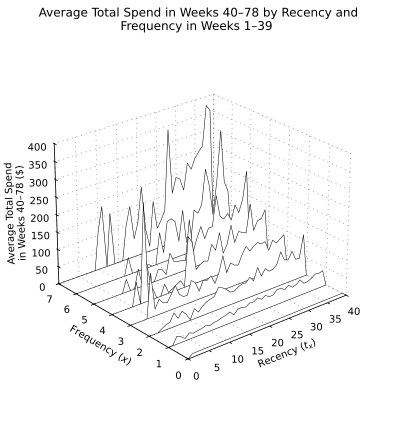

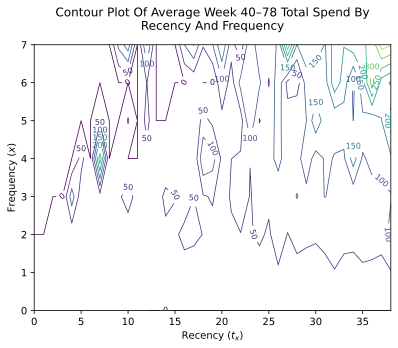

In [3]:
plot_data = (
    rfm_summary_master
    .with_columns((pl.col('p1rec') + 0.36).round(0).alias('rev_rec')) # Calendar week of the last observed purchase - Calendar Recency
    .with_columns(pl.col('P1X').cut(np.arange(7)))
    .with_columns(pl.col('rev_rec').cut(np.arange(40)))
    .collect()
    .sort('rev_rec')
    .pivot(on='rev_rec', index='P1X', values='P2X Spend', aggregate_function='mean')
    .sort('P1X')
    .fill_null(0)
    .to_numpy()
)

Z = (plot_data[:,1:]/100).astype(np.float32)

# 3D Plot
Z_mod = np.vstack([np.zeros((1, Z.shape[0])), Z.T, np.zeros((1, Z.shape[0]))])
Z_mod[1:-1,0] = Z.T[0,0]
X, Y = np.meshgrid(np.arange(Z_mod.shape[1]), np.arange(Z_mod.shape[0]))

fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection': '3d'})

for i in range(8):
    ax.fill_between(i, Y[:,i], Z_mod[:,i], 
                    i, Y[:,i], 0,
                    facecolors='white', edgecolor='black', linewidth=0.5)
    
ax.set_xlabel('Frequency ($x$)')
ax.set_ylabel('Recency ($t_{x}$)')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Average Total Spend\nin Weeks 40–78 ($)', rotation=92)
ax.zaxis.labelpad = 7
ax.set_title(" Average Total Spend in Weeks 40–78 by Recency and\nFrequency in Weeks 1–39")

ax.view_init(elev=25, azim=-40, roll=0) 

ax.set_xlim(7, 0)  
ax.set_ylim(0, 40) 
ax.set_zlim(0, 400) 

ax.grid(True, linestyle=':', color='lightgray')

ax.xaxis._axinfo['grid'].update({'linestyle': (0, (1, 5)), 'color': 'gray'})
ax.yaxis._axinfo['grid'].update({'linestyle': (0, (1, 5)), 'color': 'gray'})
ax.zaxis._axinfo['grid'].update({'linestyle': (0, (1, 5)), 'color': 'gray'})

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_box_aspect(None, zoom=0.85) 
ax.zaxis._axinfo['juggled'] = (1, 2, 0)
plt.tight_layout()
plt.show()

# Contour Plot
X, Y = np.meshgrid(np.arange(Z.shape[1]), np.arange(Z.shape[0]))

cs = plt.contour(X, Y, Z, levels=8, linewidths=0.75)
plt.clabel(cs, fontsize=8)
plt.xlabel('Recency ($t_{x}$)')
plt.ylabel('Frequency ($x$)')
plt.title('Contour Plot Of Average Week 40–78 Total Spend By\nRecency And Frequency', pad=15);

Summary of Average Repeat Transaction Value per Customer (Weeks 1-39)

In [4]:
avg_spend_calib = (
    rfm_summary_sample
    .filter(pl.col('P1X') > 0)
    .with_columns(pl.col('zbar')/100)
    .rename({'zbar': 'Avg. Spend ($)'})
    .collect()
)

kurtosis = pl.DataFrame({'statistic': 'kurtosis',
                     'Avg. Spend ($)': avg_spend_calib.select(pl.col('Avg. Spend ($)').kurtosis())})
skew = pl.DataFrame({'statistic': 'skew',
                     'Avg. Spend ($)': avg_spend_calib.select(pl.col('Avg. Spend ($)').skew())})
mode = pl.DataFrame({'statistic': 'mode',
                     'Avg. Spend ($)': avg_spend_calib.select(pl.col('Avg. Spend ($)').mode())})

# SUMMARY OF AVERAGE REPEAT TRANSACTION VALUE PER CUSTOMER (WEEKS 1–39)
with pl.Config(tbl_rows=12):
    display(avg_spend_calib.select('Avg. Spend ($)').describe().vstack(mode).vstack(skew).vstack(kurtosis).with_columns(pl.col('Avg. Spend ($)').round(2)))

statistic,Avg. Spend ($)
str,f64
"""count""",946.0
"""null_count""",0.0
"""mean""",35.08
"""std""",30.28
"""min""",2.99
"""25%""",15.76
"""50%""",27.54
"""75%""",41.79
"""max""",299.63


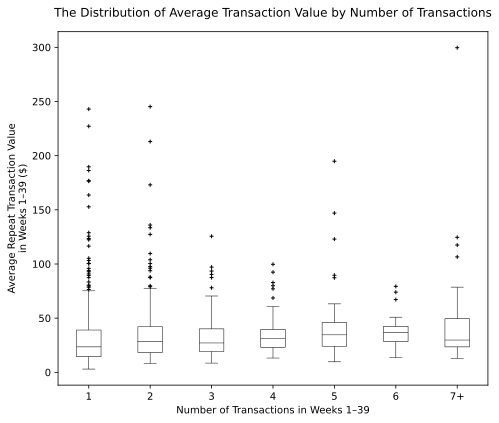

In [5]:
data = (
    avg_spend_calib
    .select('P1X', 'Avg. Spend ($)')
    .with_columns(pl.col('P1X').cut(np.arange(1,7), labels=[str(i) if i < 7 else '7+' for i in range(1,8)]))
)

plt.figure(figsize=(7,6), dpi=100)
sns.boxplot(x="P1X", y="Avg. Spend ($)", data=data, color='white', flierprops={"marker": "+", 'markersize': 4}, linecolor='black', linewidth=0.5, width=0.4)
plt.xlabel("Number of Transactions in Weeks 1–39")
plt.ylabel("Average Repeat Transaction Value\nin Weeks 1–39 ($)")
plt.title("The Distribution of Average Transaction Value by Number of Transactions", pad=15)
plt.tight_layout()
plt.show()

In [6]:
# Pareto/NBD Model
def paretonbd_params(x, t_x, T):
    
    def log_likelihood(params):
        r, alpha, s, beta = params
        
        maxab = np.max((alpha, beta))
        absab = np.abs(alpha - beta)
        param2 = s + 1
        if alpha < beta:
            param2 = r + x
            
        part1 = (alpha**r * beta**s / gamma(r)) * gamma(r+x)
        part2 = 1/((alpha+T)**(r+x) * (beta+T)**s)

        if absab == 0:
            F1 = 1/((maxab+t_x)**(r+s+x))
            F2 = 1/((maxab+T)**(r+s+x))
        else:
            F1 = hyp2f1(r+s+x, param2, r+s+x+1, absab/(maxab+t_x)) / ((maxab+t_x)**(r+s+x))
            F2 = hyp2f1(r+s+x, param2, r+s+x+1, absab/(maxab+T)) / ((maxab+T)**(r+s+x))        
        
        return -np.sum(np.log(part1*(part2+(s/(r+s+x))*(F1-F2))))
    
    bnds = [(1e-6, 20) for _ in range(4)]
    guess = [0.01 for _ in range(4)]
    return minimize(log_likelihood, x0=guess, bounds=bnds)

def paretonbd_pmf(f_x, t, r, alpha, s, beta_param):
    '''
    P(X(t) = x | r, alpha, s, beta) where the random variable X(t) denotes the number of transactions in the 
    interval (0, t] for a randomly-chosen individual
    '''
    maxab = np.max((alpha, beta_param))
    absab = np.abs(alpha - beta_param)
    param2 = s + 1
    if alpha < beta_param:
        param2 = r + f_x    
    B2i = np.cumsum(
        gamma(r+s+f_x)/gamma(r+s) * t**f_x / factorial(f_x) *
        hyp2f1(r+s+f_x, param2, r+s+f_x+1, absab/(maxab+t)) / 
        (maxab+t)**(r+s+f_x),
        axis=0
    )
    pmf = (
        gamma(r+f_x)/(gamma(r)*factorial(f_x)) *
        (alpha/(alpha+t))**r * 
        (t/(alpha+t))**f_x *
        (beta_param/(beta_param+t))**s +
        alpha**r * beta_param**s *
        beta(r+f_x,s+1)/beta(r,s) *
        (hyp2f1(r+s, param2, r+s+f_x+1, absab/maxab) / maxab**(r+s) - B2i)
    )
    return pmf

def paretonbd_E_X_t(t, r, alpha, s, beta_param):
    '''
    E[X(t) | r, alpha, s, beta], the expected number of transactions in a time period of length t
    central to computing the e thxpected transaction volume fore whole customer base over time
    '''
    return r*beta_param/(alpha*(s-1)) * (1 - (beta_param/(beta_param + t))**(s-1))

def paretonbd_pactive(x, t_x, T, r, alpha, s, beta_param):
    '''
    P(“active”|r, alpha, s, beta, X = x, tx, T), the probability that a customer with observed 
    behavior (X = x, tx, T) is still active at time T
    '''
    maxab = np.max((alpha, beta_param))
    absab = np.abs(alpha - beta_param)
    param2 = s + 1
    if alpha < beta_param:
        param2 = r + x

    F0 = (alpha + T)**(r + x) * (beta_param + T)**s

    if absab == 0:
        F1 = 1/((maxab+t_x)**(r+s+x))
        F2 = 1/((maxab+T)**(r+s+x))
    else:
        F1 = hyp2f1(r+s+x, param2, r+s+x+1, absab/(maxab+t_x)) / ((maxab+t_x)**(r+s+x))
        F2 = hyp2f1(r+s+x, param2, r+s+x+1, absab/(maxab+T)) / ((maxab+T)**(r+s+x))       

    return (1 + (s / (r+s+x)) * F0 * (F1-F2))**(-1)

def paretonbd_E_Y_X(x, t_x, T, t, r, alpha, s, beta_param):
    '''
    E(Y(t)|X = x, tx, T, r, alpha, s, beta), the expected number of transactions in the future 
    period (T, T + t] for a customer with observed behavior (X = x, tx, T)
    '''
    return (
        (r + x) * (beta_param + T) / ((alpha + T) * (s - 1)) *
        (1 - ((beta_param + T) / (beta_param + T + t))**(s - 1)) *
        paretonbd_pactive(x, t_x, T, r, alpha, s, beta_param)
    )
    
def paretonbd_cum_repeat_trans(n_s, s, t, r, alpha, s_param, beta_param, period=7):
    E_X_t = paretonbd_E_X_t(t, r, alpha, s_param, beta_param)
    s = np.arange(np.max(s)*period - 1, -1, -1, dtype=np.int32)
    t = np.arange(np.max(t)*period, dtype=np.int32).reshape(-1,1)
    index = np.clip(t - s, 0, len(E_X_t))
    E_X_t = np.where(t > s, E_X_t[index-1], 0)
    return np.dot(E_X_t, n_s)[6::7]

In [7]:
res = paretonbd_params(repeat_trans_calib, last_purch, T)
r_pareto, alpha_pareto, s, beta_param = res.x
ll = res.fun

display_markdown(f'''**Pareto/NBD:**

Parameter Estimates:
- $r$ = {r_pareto:0.4f}
- $\\alpha$ = {alpha_pareto:0.4f}
- $s$ = {s:0.4f}
- $\\beta$ = {beta_param:0.4f}

Log-Likelihood = {-ll:0.4f}''', raw=True)

**Pareto/NBD:**

Parameter Estimates:
- $r$ = 0.5533
- $\alpha$ = 10.5781
- $s$ = 0.6064
- $\beta$ = 11.6726

Log-Likelihood = -9594.9762

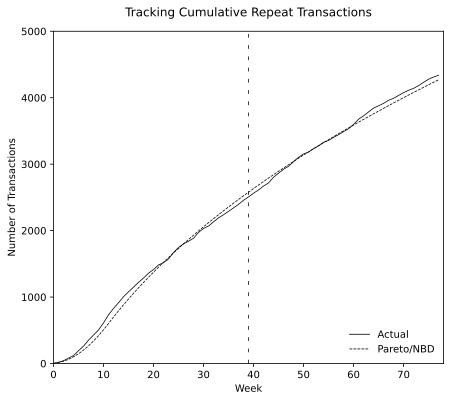

In [8]:
actual_cum_repeat, actual_wkly_sales, actual_cum_repeat = np.hsplit(CDNOW(master=False, calib_p=273).repeat_sales().to_numpy(), 3)

# n_s is the number of customers who made their first purchase on day s
# T_unique is the unique t - s/7 weeks within which to make repeat purchases
T_unique, n_s = np.unique(T, return_counts=True)

forecast_horizon = np.arange(1/7, 78, 1/7) # day-by-day in weeks
calib_p = 39 # in weeks

paretonbd_cum_repeat = paretonbd_cum_repeat_trans(n_s, calib_p-T_unique, forecast_horizon, r_pareto, alpha_pareto, s, beta_param)
paretonbd_wkly_repeat = np.diff(paretonbd_cum_repeat, prepend=0)

forecast_horizon = np.arange(78)
plt.figure(figsize=(7,6), dpi=100)
plt.plot(forecast_horizon, actual_cum_repeat, color='black', linestyle='solid', linewidth=0.75, label='Actual')
plt.plot(forecast_horizon, paretonbd_cum_repeat, color='black', linestyle='--', linewidth=0.75, label='Pareto/NBD')
plt.plot([calib_p for _ in range(5000)], [_ for _ in np.arange(5000)], color='black', linestyle=(0, (5, 10)), linewidth=0.75)
plt.xlabel("Week")
plt.ylabel("Number of Transactions")
plt.title('Tracking Cumulative Repeat Transactions', pad=15)
plt.ylim(0,5000)
plt.xlim(0, 78)
plt.legend(loc=4, frameon=False);

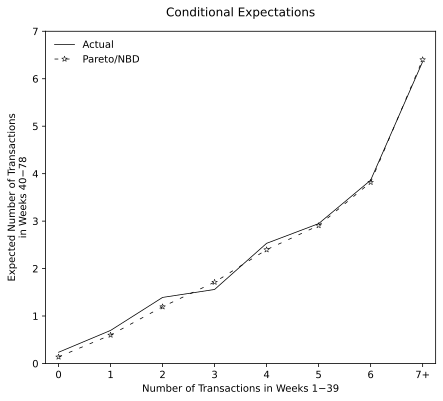

In [9]:
actual_ce = (
    CDNOW(master=False, calib_p=273)
    .rfm_summary()
    .group_by('P1X').agg(pl.col('P2X').mean().alias('Actual CE'))
    .sort('P1X').select('Actual CE')
)

t = 39 # the length of the period over which we wish to make the conditional forecast
paretonbd_ce = paretonbd_E_Y_X(repeat_trans_calib, last_purch, T, t, r_pareto, alpha_pareto, s, beta_param)

paretonbd_ce, actual_ce  =  np.hsplit(
    pl.DataFrame({'x': repeat_trans_calib.astype(np.int32).flatten(), 
                  'Pareto/NBD -  E(Y|X)': paretonbd_ce.flatten()})
    .group_by('x')
    .agg(pl.col('Pareto/NBD -  E(Y|X)').mean())
    .sort('x').hstack(actual_ce.collect()).drop('x').to_numpy(), 2
)

censor = 7

num_repeats, repeat_freq = np.unique(repeat_trans_calib, return_counts=True)
num_repeats_censored = num_repeats[:censor+1].copy()

actual_ce_censored = actual_ce[:censor+1].copy()
actual_ce_censored[-1] = np.dot(repeat_freq[censor:], actual_ce[censor:]) / np.sum(repeat_freq[censor:])

paretonbd_ce_censored = paretonbd_ce[:censor+1].copy()
paretonbd_ce_censored[-1] = np.dot(repeat_freq[censor:], paretonbd_ce[censor:]) / np.sum(repeat_freq[censor:])

plt.figure(figsize=(7,6), dpi=100)
plt.plot(num_repeats_censored, actual_ce_censored, color='black', linestyle='solid', linewidth=0.75, label='Actual')
plt.plot(num_repeats_censored, paretonbd_ce_censored, color='black', linestyle=(0, (5, 10)), marker='*', fillstyle='none', markeredgewidth=0.5, linewidth=0.75, label='Pareto/NBD')
plt.xlabel("Number of Transactions in Weeks 1−39")
plt.ylabel("Expected Number of Transactions\nin Weeks 40−78")
plt.title('Conditional Expectations', pad=15)
plt.xticks(num_repeats_censored, [0,1,2,3,4,5,6,'7+'])
plt.ylim(0,7)
plt.xlim(-0.25, 7.25)
plt.legend(loc=2, frameon=False); 

In [55]:
def gammagamma_params(x, zbar):
    
    def log_likelihood(params):
        p, q, gamma_param = params
        return -np.sum(
            gammaln(p*x+q)-gammaln(p*x)-gammaln(q) + 
            q*np.log(gamma_param)+(p*x-1)*np.log(zbar) + 
            (p*x)*np.log(x)-(p*x+q)*np.log(gamma_param+x*zbar)
        )

    guess=[0.01, 0.01, 0.01]
    bnds = [(1e-6, np.inf) for _ in range(3)]
    return minimize(log_likelihood, x0=guess, bounds=bnds)

x, zbar = np.hsplit(avg_spend_calib.select('P1X','Avg. Spend ($)').to_numpy(), 2)
res = gammagamma_params(x=x, zbar=zbar)
p, q, gamma_param = res.x
ll = res.fun

display_markdown(f'''$p$ = {p:0.4f}

$q$ = {q:0.4f}

$\\gamma$ = {gamma_param:0.4f}

Log-Likelihood = {-ll:0.4f}''', raw=True)

$p$ = 6.2502

$q$ = 3.7442

$\gamma$ = 15.4419

Log-Likelihood = -4055.9177

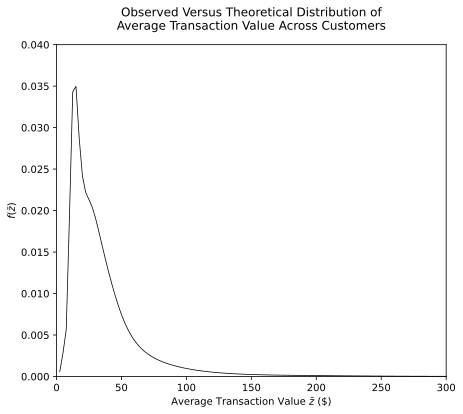

In [43]:
zbar = avg_spend_calib.select('Avg. Spend ($)').to_numpy()
m = np.arange(2.5, 301, 2.5) # Average transaction value range

# Apply log transformation for boundary correction
m_log = np.log(m)
zbar_log = np.log(zbar)

bw = modified_silverman(zbar_log)

# Estimate the probability density function
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(zbar_log.reshape(-1,1))
log_density = kde.score_samples(m_log.reshape(-1,1))
f = np.exp(log_density) / m # Transform the density back to the original scale

plt.figure(figsize=(7,6), dpi=100)
plt.plot(m, f, color='black', linestyle='solid', linewidth=0.75, label='Actual')
plt.xlabel(r'Average Transaction Value $\bar{z}$ (\$)')
plt.ylabel(r'$f(\bar{z})$')
plt.title('Observed Versus Theoretical Distribution of\nAverage Transaction Value Across Customers', pad=15)
plt.ylim(0,0.04)
plt.xlim(0, 300);